# 模块的设计说明

---

## 1. `ParticleEventSimulator`：事件仿真核心模块

**职责：**

* 模拟粒子在流场中的运动；
* 渲染粒子图像帧；
* 提取事件相机模拟输出。

**核心流程：**

* `init_particles()`：初始化粒子位置与属性（位置、尺寸、亮度）；
* `update_particles(pts)`：粒子在速度场中按时间推进；
* `frame_from_particles(particles)`：粒子投影成灰度图像（高斯扩散）；
* `frames_to_events(frames, ts)`：图像序列转换为事件流（基于亮度变化）；
* `forward()`：完整仿真流程，返回事件与速度场；
* `export_frames_to_video()`：图像帧导出为 MP4 视频。

---

## 2. `EventDataSource` 及其子类：事件数据读取模块

**设计理念：**

* 统一接口 `load()`，封装各类事件数据读取；
* 子类支持不同数据格式，符合开闭原则。

**子类实现：**

* `RealEventFileSource`：标准 HDF5 格式；
* `EVK5EventFileSource`：EVK5 相机专用格式；
* `NpzEventFileSource`：NumPy `.npz` 压缩格式。

---

## 3. `EventManager`：事件数据统一入口管理类

**功能：**

* 提供统一 `load()` 接口，支持模拟与多种真实数据源；
* 根据 `source_type` 自动构建对应数据源对象。

**内部逻辑：**

* `_create_source()`：根据类型选择相应加载类；
* `load()`：调用数据源加载事件，缓存为 `self.evts, self.flow`。

---


In [1]:
# # **** event_loarder.py **************
# import h5py
# import numpy as np
# import cv2
# import scipy.special as ss
# from scipy.integrate import cumtrapz
# import copy
# from addict import Dict

# def config():
#     cfg = Dict()
#     # single image
#     cfg.density = 0.01
#     cfg.width = 256
#     cfg.height = 256
#     cfg.d = 4.2
#     cfg.d_std = 0.2
#     cfg.l = 200
#     cfg.l_std = 10

#     # videos
#     cfg.time_length = 15   # in ms;

#     # event
#     cfg.threshold = 0.25 # the constant fire threshold
    
#     return cfg

# class ParticleEventSimulator:
#     """
#     模拟粒子在速度场中运动并生成事件图像的模拟器。

#     核心流程包括：
#     - 初始化粒子分布
#     - 粒子在流场中随时间演化
#     - 基于粒子生成每一帧图像
#     - 从图像序列中提取事件（模拟事件相机原理）
#     """

#     def __init__(self, flow, cfg):
#         """
#         初始化模拟器。
        
#         参数：
#         - flow: 函数，接收 (x, y) 并返回速度场 (u, v)
#         - cfg: 配置对象，包含模拟所需参数
#         """
#         self._c = cfg
#         self.flow = flow

#     def load(self, cfg=None):
#         return self.forward(cfg)

#     def init_particles(self):
#         """
#         S1 - 随机初始化粒子的位置和属性。

#         返回：
#         - 一个包含初始粒子状态的列表（通常仅一个 Dict 对象）
#         """
#         cfg = self._c
#         num = int(9 * cfg.width * cfg.height * cfg.density + 0.5)
#         pts = Dict()
#         pts.x = np.random.uniform(-cfg.height, 2 * cfg.height, num)
#         pts.y = np.random.uniform(-cfg.width, 2 * cfg.width, num)
#         pts.d = np.abs(np.random.randn(num) * cfg.d_std + cfg.d)
#         pts.l = np.abs(np.random.randn(num) * cfg.l_std + cfg.l)
#         return [pts]

#     def update_particles(self, pts):
#         """
#         S2 - 根据流场计算粒子轨迹随时间的演化。

#         参数：
#         - pts: 初始粒子状态

#         返回：
#         - pts_list: 所有时间点的粒子状态列表
#         - ts: 每个状态对应的时间戳列表
#         """
#         u, v = self.flow(pts.x, pts.y)
#         max_value = np.max([np.max(np.abs(u)), np.max(np.abs(v))])
#         delta_t = 0.2 / max_value

#         num = int(round(self._c.time_length / delta_t)) + 1
#         ts = np.linspace(0, self._c.time_length, num)
#         delta_t = self._c.time_length / (num - 1)

#         pts_list = [copy.deepcopy(pts) for _ in range(num)]
#         for k in range(1, num):
#             x, y = pts_list[k - 1].x, pts_list[k - 1].y
#             u, v = self.flow(x, y)
#             pts_list[k].x = x + u * delta_t
#             pts_list[k].y = y + v * delta_t

#         return pts_list, ts

#     def frame_from_particles(self, particles):
#         """
#         S3 - 根据粒子信息生成图像帧（粒子投影为图像亮度）。

#         参数：
#         - particles: 单个时间点的粒子状态

#         返回：
#         - image: 2D numpy 图像数组（float）
#         """
#         cfg = self._c
#         image = np.zeros((cfg.height, cfg.width))
#         xrange, yrange = np.meshgrid(np.arange(cfg.height), np.arange(cfg.height), indexing='ij')

#         for x, y, d, l in zip(particles.x, particles.y, particles.d, particles.l):
#             if x + 3 * d + 2 < 0 or x - 3 * d - 2 > cfg.height or y + 3 * d + 2 < 0 or y - 3 * d - 2 > cfg.width:
#                 continue

#             x1 = int(min(max(0, x - 3 * d - 2), cfg.height - 6 * d - 3))
#             y1 = int(min(max(0, y - 3 * d - 2), cfg.width - 6 * d - 3))
#             x2 = x1 + int(6 * d + 3)
#             y2 = y1 + int(6 * d + 3)

#             lx = xrange[x1:x2, y1:y2] - x
#             ly = yrange[x1:x2, y1:y2] - y

#             b = d / np.sqrt(8)
#             area = ((ss.erf((lx + 0.5) / b) - ss.erf((lx - 0.5) / b)) *
#                     (ss.erf((ly + 0.5) / b) - ss.erf((ly - 0.5) / b)) /
#                     (1.5 * (ss.erf(0.5 / b) - ss.erf(-0.5 / b)) ** 2))

#             image[x1:x2, y1:y2] += area * l

#         return np.clip(image, 0, 255)

#     def frames_to_events(self, frames, ts):
#         """
#         S4 - 从图像帧序列中提取事件流（模拟事件相机输出）。

#         参数：
#         - frames: 帧序列，形状为 [t, x, y]
#         - ts: 每一帧对应的时间戳

#         返回：
#         - events: N×4 numpy 数组，每行为 (x, y, t, polarity)
#         """
#         cfg = self._c
#         array3d = np.array(frames)
#         array = np.log(array3d + 1)

#         prev_vals = array[:-1, :, :]
#         next_vals = array[1:, :, :]
#         diffs = next_vals - prev_vals

#         c_list = np.arange(0, 1.0, cfg.threshold) * np.max(array)

#         events = []
#         for c in c_list:
#             mask = (((prev_vals <= c) & (c <= next_vals)) |
#                     ((next_vals <= c) & (c <= prev_vals))) & (diffs != 0)

#             i_indices, x_indices, y_indices = np.where(mask)

#             a = prev_vals[mask]
#             b = next_vals[mask]
#             proportions = (c - a) / (b - a)
#             t_values = ts[i_indices] + proportions * (ts[i_indices + 1] - ts[i_indices])
#             polars = (a <= c) & (c <= b)

#             events.extend(zip(x_indices, y_indices, t_values, polars.astype(int)))

#         return np.array(events)

#     def flow_field(self):
#         """
#         生成当前配置下的速度真值场 (u, v)
        
#         该函数用于在整个图像平面（由 cfg.width 和 cfg.height 指定）上，
#         生成每个像素位置的速度矢量分量。
        
#         返回：
#         - u: numpy数组，形状为 [H, W]，表示每个位置的水平速度分量
#         - v: numpy数组，形状为 [H, W]，表示每个位置的垂直速度分量
#         """
#         x = np.arange(self._c.height)
#         y = np.arange(self._c.width)
#         xx, yy = np.meshgrid(x, y, indexing='ij')
#         u, v = self.flow(xx, yy)
#         return u, v

#     def forward(self, cfg=None):
#         """
#         执行完整仿真流程，包括粒子生成、运动、图像生成和事件提取。

#         参数：
#         - cfg: 可选，替换当前配置

#         返回：
#         - evts: 最终输出的事件列表 (x, y, t, polarity)
#         """
#         if cfg is not None:
#             self._c = cfg
#         pts = self.init_particles()[0]
#         pts_list, ts = self.update_particles(pts)
#         self.imgs = [self.frame_from_particles(pts) for pts in pts_list]
#         evts = self.frames_to_events(self.imgs, ts)
#         u,v = self.flow_field()
#         return evts, (u,v)

#     def export_frames_to_video(self, output_file="output/output.mp4"):
#         """
#         将生成的图像帧序列导出为 MP4 视频文件。
        
#         参数：
#         - output_file: 输出视频文件路径（默认 "output.mp4"）
        
#         要求：
#         - self.imgs: 已生成的图像帧列表，形状为 [H, W]，灰度图
#         """
#         fps = int(len(self.imgs)/15)  # 帧率，可根据模拟需要调整
    
#         if not hasattr(self, 'imgs') or len(self.imgs) == 0:
#             raise ValueError("图像帧未生成，请先运行 forward() 或生成 self.imgs")
    
#         # 自动获取帧大小（支持任意宽高）
#         frame_height, frame_width = self.imgs[0].shape
#         video_size = (frame_width, frame_height)
    
#         # 初始化视频写入器
#         fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#         video_writer = cv2.VideoWriter(output_file, fourcc, fps, video_size)
    
#         for frame in self.imgs:
#             # 确保类型和通道数为 uint8 & RGB
#             if frame.dtype != np.uint8:
#                 frame = np.clip(frame, 0, 255).astype(np.uint8)
#             if frame.ndim == 2:
#                 frame = np.stack([frame] * 3, axis=-1)  # 灰度转RGB
    
#             video_writer.write(frame)
    
#         video_writer.release()
#         print(f"[INFO] 视频保存至 {output_file}")



# class EventDataSource:
#     def __call__(self, cfg=None):
#         return self.load()
        
#     def load(self):
#         raise NotImplementedError

# class RealEventFileSource(EventDataSource):
#     def __init__(self, file_path):
#         self.file_path = file_path

#     def load(self):
#         with h5py.File(self.file_path, 'r') as h5f:
#             evts = np.transpose(np.array([
#                 h5f["events/x"],
#                 h5f["events/y"],
#                 h5f["events/t"]/1000,
#                 h5f["events/p"]
#             ]))
#         return evts, (None,None)

# class EVK5EventFileSource(EventDataSource):
#     def __init__(self, file_path):
#         self.file_path = file_path

#     def load(self):
#         with h5py.File(self.file_path, 'r') as h5f:
#             evts = np.transpose(np.array([
#                 h5f["CD/events"]["x"],
#                 h5f["CD/events"]["y"],
#                 h5f["CD/events"]["t"]/1000,
#                 h5f["CD/events"]["p"]
#             ]))
#         return evts, (None,None)

# class NpzEventFileSource(EventDataSource):
#     def __init__(self, file_path):
#         self.file_path = file_path

#     def load(self):
#         evts = np.load(self.file_path)['evts']
#         return evts, (None,None)


# class EventManager:
#     def __init__(self, source_type, path=None, cfg=None, flow_func=None):
#         """
#         source_type: 'simulator', 'real', 'evk5', 'npz'
#         path: 文件路径（模拟器无需）
#         cfg: 模拟器配置
#         flow: 模拟器使用的速度场函数
#         """
#         self.source_type = source_type.lower()
#         self.path = path
#         self.cfg = cfg
#         self.flow_func = flow_func
#         self.evts = None
#         self.flow = None

#         self.source = self._create_source()

#     def _create_source(self):
#         if self.source_type == "simulator":
#             if self.flow_func is None:
#                 raise ValueError("模拟器模式必须提供 flow 函数")
#             return ParticleEventSimulator(flow=self.flow_func, cfg=self.cfg)
#         elif self.source_type == "real":
#             return RealEventFileSource(self.path)
#         elif self.source_type == "evk5":
#             return EVK5EventFileSource(self.path)
#         elif self.source_type == "npz":
#             return NpzEventFileSource(self.path)
#         else:
#             raise ValueError(f"Unsupported source_type: {self.source_type}")

#     def load(self):
#         self.evts, self.flow = self.source.load()
#         return self.evts, self.flow


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from flow import FlowManager
from event_loader import config, EventManager

from visualizer import plot_events_3d,plot_event_time2d,save_voxel_grid_video, plot_flow_field

np.random.seed(100)

[INFO] 视频保存至 output/output.mp4
Figure saved to output/event3d_1.png


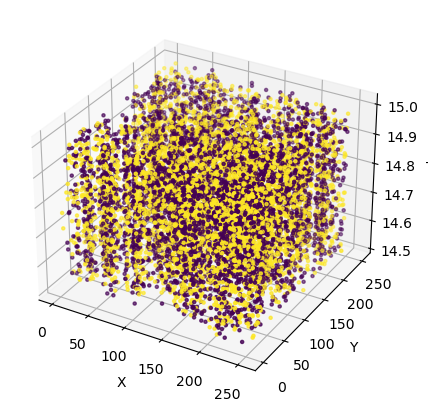

Figure saved to output/event2d_1.png


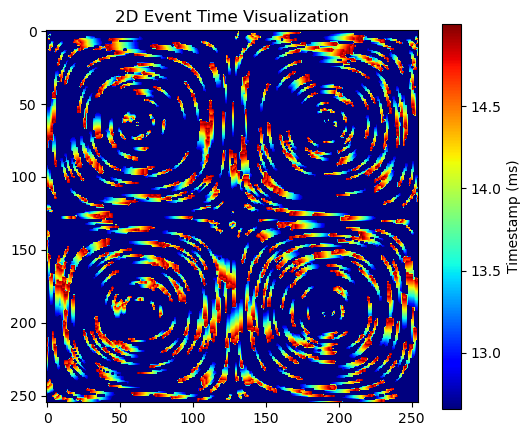

[INFO] 视频保存至 output/loader_voxelgrids_1.mp4


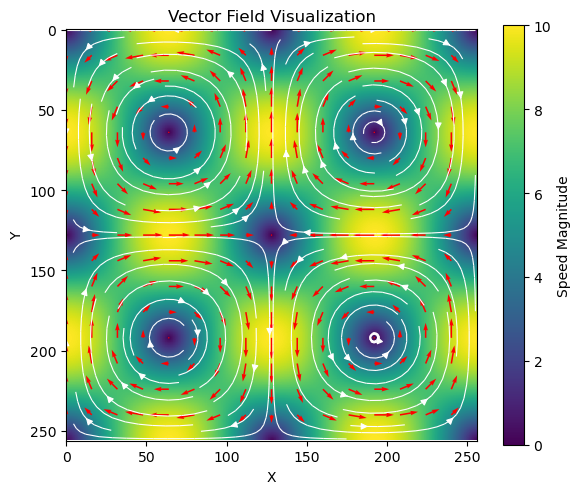

In [3]:
# Test 1， 仿真器生成
def test1():
    # flow = FlowManager(mode="data", data_path="./data/backstep_Re1000_00004.npz")
    # flow = FlowManager(mode="analytical", name="uniform", uc=2.5,vc=0.02)
    # flow = FlowManager(mode="analytical", name="solid_rot", x_c=128,y_c=128, omega=0.05)
    # flow = FlowManager(mode="analytical", name="sin_flow", x_c=128,y_c=128, a=6, b=128, scale=5)
    flow = FlowManager(mode="analytical", name="cellular_flow", vmax=10, p=256)
    
    flow_func = flow.evaluate
    
    cfg = config() # 支持不同的配置，默认设置见定义
    cfg.time_length=15
    event_loader = EventManager(source_type="simulator", path=None, cfg=cfg, flow_func=flow_func)
    evts, (u,v) = event_loader.load()
    event_loader.source.export_frames_to_video()
    
    # show_events(evts)
    plot_events_3d(evts, output_file="output/event3d_1.png", startN=-10000, endN=-1)
    plot_event_time2d(evts[-50000:,:], output_file="output/event2d_1.png", vmin=None, vmax=None)
    save_voxel_grid_video(evts, output_file="output/loader_voxelgrids_1.mp4", img_size=(256,256), fps=10)
    
    # show_vecs(u,v)
    plot_flow_field(u,v)

test1()

Figure saved to output/event3d_2.png


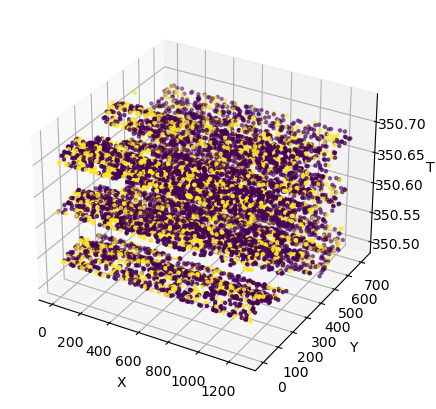

Figure saved to output/event2d_2.png


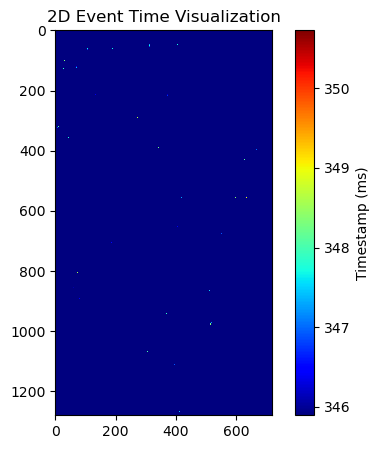

[INFO] 视频保存至 output/loader_voxelgrids_2.mp4


In [4]:
# Test 2， 读取real数据
def test2():
    path = "./data/ebiv_wallflow4_dense_3.h5"
    event_loader = EventManager(source_type="real", path=path, cfg=None, flow_func=None)
    evts, (u,v) = event_loader.load()
    # show_events(evts)
    plot_events_3d(evts, output_file="output/event3d_2.png", startN=-10000, endN=-1)
    plot_event_time2d(evts[-200000:,:], output_file="output/event2d_2.png", vmin=None, vmax=None)
    save_voxel_grid_video(evts, output_file="output/loader_voxelgrids_2.mp4", img_size=(1280,720), fps=10)

test2()

719.0
Figure saved to output/event3d.png


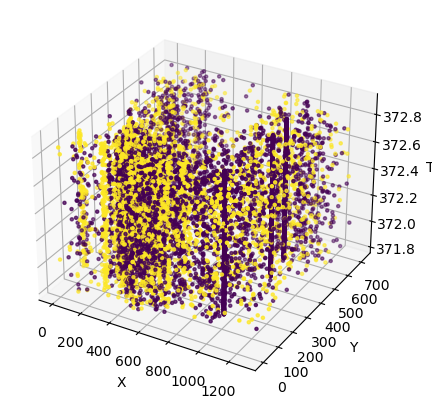

Figure saved to output/event2d_3.png


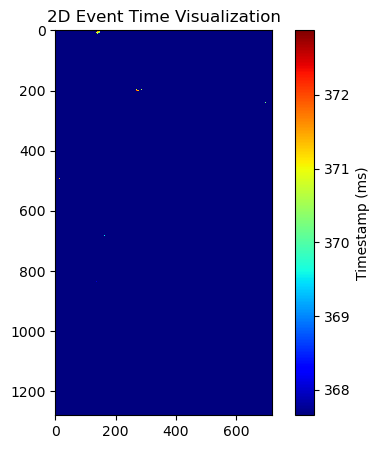

[INFO] 视频保存至 output/loader_voxelgrids_3.mp4


In [5]:
# Test 3， 读取evk5数据
def test3():
    path = "./data/evk5_rot1.hdf5"
    event_loader = EventManager(source_type="evk5", path=path, cfg=None, flow_func=None)
    evts, (u,v) = event_loader.load()
    print(np.max(evts[:,1]))
    
    # show_events(evts)
    plot_events_3d(evts, output_file="output/event3d.png", startN=-10000, endN=-1)
    plot_event_time2d(evts[-50000:,:], output_file="output/event2d_3.png", vmin=None, vmax=None)
    save_voxel_grid_video(evts, output_file="output/loader_voxelgrids_3.mp4", img_size=(1280,720), fps=10)

test3()

Figure saved to output/event3d.png


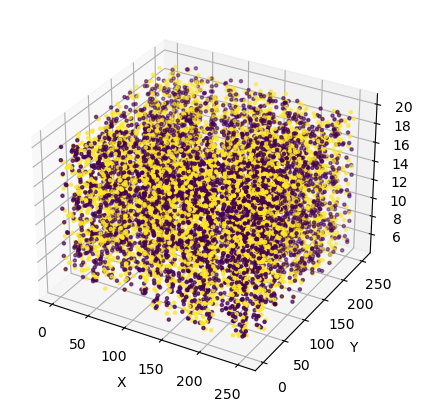

Figure saved to output/event2d_4.png


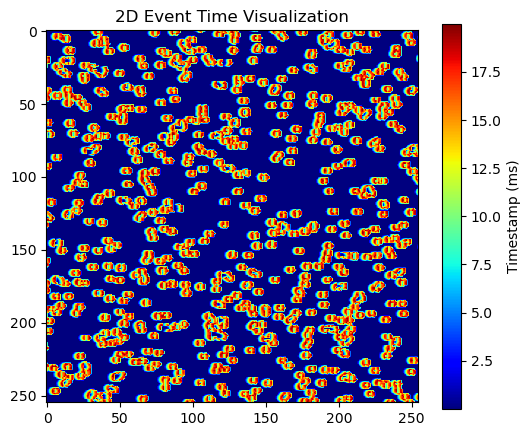

[INFO] 视频保存至 output/loader_voxelgrids_4.mp4


In [6]:
# Test 4， 读取npz数据
def test4():
    path = "./data/events.npz"
    event_loader = EventManager(source_type="npz", path=path, cfg=None, flow_func=None)
    evts, (u,v) = event_loader.load()
    
    # show_events(evts)
    plot_events_3d(evts, output_file="output/event3d.png", startN=-10000, endN=-1)
    plot_event_time2d(evts[-50000:,:], output_file="output/event2d_4.png", vmin=None, vmax=None)
    save_voxel_grid_video(evts, output_file="output/loader_voxelgrids_4.mp4", img_size=(256,256), fps=10)

test4()